In [21]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm 
import bottleneck as bn

## Load Important Function

In [3]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [4]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [39]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 3) array of binary states into (N, M) indices in [0..7].

    Mapping:
      - [a, b, c] are binary bits (0 or 1), forming a 3-bit number: a*4 + b*2 + c
      - NaN-safe: if any of the 3 elements is NaN, output is NaN

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 3).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M) with values in [0..7] or NaN.
    """
    all_state_array = np.array(all_state, dtype=float)

    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 3:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 3).")

    nan_mask = np.isnan(all_state_array).any(axis=-1)
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    valid_mask = ~nan_mask
    valid_data = all_state_array[valid_mask]  # shape (?, 3)

    a = valid_data[:, 0]
    b = valid_data[:, 1]
    c = valid_data[:, 2]

    result = (a * 4 + b * 2 + c).astype(float)
    indexed_states[valid_mask] = result

    return indexed_states


In [40]:
def index_to_state(index):
    """Converts an index (0-7) into a (3,) binary state array."""
    if not (0 <= index < 8):  # Ensure valid range (0-7)
        raise ValueError(f"Index out of range: {index}. Expected 0-7.")

    # Convert index to a 3-bit binary string
    binary_str = format(index, '03b')  # Example: 3 -> '011'
    
    # Convert binary string to NumPy array of integers
    state = np.array([int(bit) for bit in binary_str], dtype=int)

    return state

In [6]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## Make a whole np traj.shape (742, 196095, 3) with nan, and convert the [111] into individual 8 state, then index it to (742, 196095)

In [7]:
omegas_by_result = []  # To store processed omega data
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (742, x, 3) array

In [8]:
print(len(all_omega)) 

all_omega[0].shape
all_omega[0]

742


array([[-173.65106  ,    8.187268 ,  158.7122   ],
       [ 149.942    ,   -5.472654 , -179.34113  ],
       [ 162.98587  ,    2.9294653, -170.57141  ],
       ...,
       [ -25.63846  ,    6.4290886, -142.46432  ],
       [  -1.3674331,   47.98817  , -169.6922   ],
       [ -16.094692 ,   27.522018 ,  177.88043  ]], dtype=float32)

In [10]:
## Create a (ntraj, ntimestep) with 3 binary cistrans convert to conform state [0...7]

ntraj = len(all_omega)
all_cistrans = []
for i in range(ntraj):
    all_cistrans.append(omega2cistrans(all_omega[i]))

all_cistrans

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

print('traj.shape', traj.shape)


all_traj_indexed = state_to_index_vectorized(traj)

all_traj_indexed = np.array(all_traj_indexed)
print('all_traj_indexed.shape', all_traj_indexed.shape)
all_traj_indexed[1]


maxlength 196095
traj.shape (742, 196095, 3)
all_traj_indexed.shape (742, 196095)


array([ 1.,  1.,  1., ..., nan, nan, nan])

(196095,)


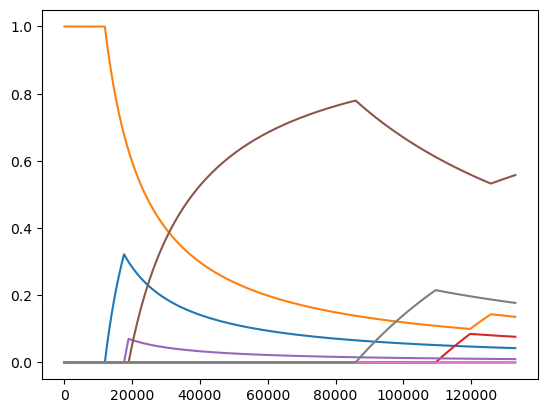

In [11]:
conform_num = 8

conform_population = calculate_conform_p(all_traj_indexed[1], conform_num)
print(all_traj_indexed[0].shape)
plt.plot(conform_population.T)  # Transpose: shape (37002, 32)
#plt.ylim(0, 0.125)

Processing all trajectories: 100%|██████████| 742/742 [00:11<00:00, 63.62it/s]


maxlength 196095


Processing each conformation: 100%|██████████| 8/8 [00:00<00:00, 13.64it/s]


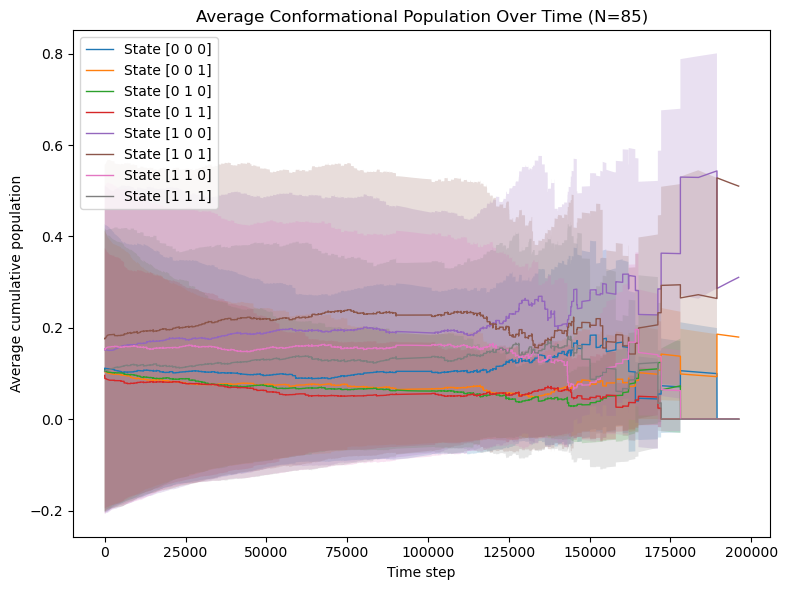

In [41]:
conform_num = 8
n_traj = all_traj_indexed.shape[0]

# Store population results from each trajectory
all_conform_populations = []

for i in tqdm(range(n_traj), desc="Processing all trajectories"):
    single_traj = all_traj_indexed[i]
    # Skip NaNs inside calculate_conform_p
    conform_p = calculate_conform_p(single_traj, conform_num)
    all_conform_populations.append(conform_p)

# Find the longest trajectory (in terms of time steps)
maxlength = max([all_conform_populations[i].shape[1] for i in range(n_traj)])
print('maxlength', maxlength)

# Make an array to store all the conformational populations with padding
all_conform_p = np.full((n_traj, conform_num, maxlength), np.nan)

for i in tqdm(range(n_traj), desc="Processing all trajectories"):
    conform_p = all_conform_populations[i]
    time_len = conform_p.shape[1]
    all_conform_p[i, :, :time_len] = conform_p

avg_conform_population = bn.nanmean(all_conform_p, axis=0)
std_conform_population = bn.nanstd(all_conform_p, axis=0)

T = avg_conform_population.shape[1]
x = np.arange(T)

plt.figure(figsize=(8, 6))

for i in tqdm(range(conform_num), desc="Processing each conformation"):  # loop over all 8 states
    mean = avg_conform_population[i]
    std = std_conform_population[i]
    
    plt.plot(x, mean, label=f"State {index_to_state(i)}", linewidth=1)
    plt.fill_between(x, mean - std, mean + std, alpha=0.2)
    #plt.ylim(0, 0.125)
plt.xlabel("Time step")
plt.ylabel("Average cumulative population")
plt.title("Average Conformational Population Over Time (N=85)")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Error Over Times

In [ ]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime_8conform.csv")
#print(df_stationary_p)


# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='mean')
pivot_std = df_stationary_p.pivot(index='thermo_state', columns='conform_state', values='std')

# Convert to NumPy arrays
trans_refer = pivot_mean.to_numpy()  # shape (1, 8) state, residues 
trans_refer_err = pivot_std.to_numpy()  # shape (1, 8)
trans_refer.shape

(1, 8)

In [32]:
trans_refer.shape

(1, 8)

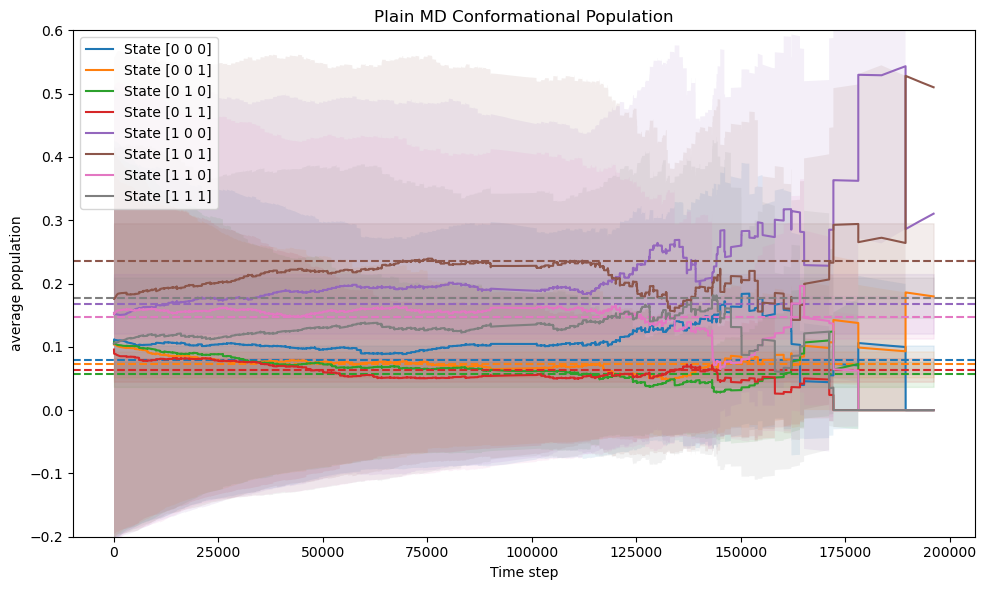

In [42]:
conform_state = 8

plt.figure(figsize=(10, 6))

for idx in range(conform_state):
    mean = avg_conform_population[idx]
    std = std_conform_population[idx]

    plt.plot(x, mean, label=f"State {index_to_state(idx)}")
    plt.fill_between(
        x,
        mean - std,
        mean + std,
        alpha=0.1
    )

    # Reference line
    ref_y = trans_refer[0, idx]
    ref_yerr = trans_refer_err[0, idx]

    plt.axhline(y=ref_y, linestyle='--', color=f'C{idx}', alpha=1)
    plt.fill_between(
        x,
        ref_y - ref_yerr,
        ref_y + ref_yerr,
        color=f'C{idx}',
        alpha=0.1
    )

plt.ylim(-0.2, 0.6)
plt.xlabel("Time step")
plt.ylabel("average population")
plt.title(f"Plain MD Conformational Population")
plt.legend()
plt.tight_layout()
plt.show()


### Plot the ERROR

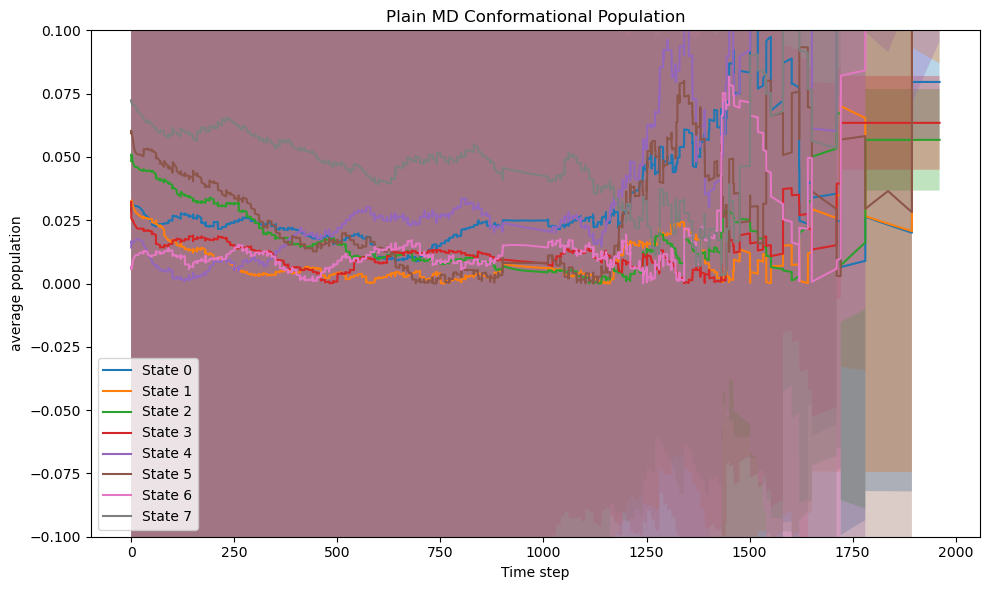

In [44]:
conform_state = 8
dt_in_ns = 0.01

plt.figure(figsize=(10, 6))

for idx in range(conform_state):
    mean = avg_conform_population[idx]
    std = std_conform_population[idx]
    # Reference line
    ref_y = trans_refer[0, idx]
    ref_yerr = trans_refer_err[0, idx]

    error = mean - ref_y
    error_abs = np.abs(error)
    error_err = np.sqrt(std**2 + ref_yerr**2)
    plt.plot(x*dt_in_ns, error_abs, label=f"State {idx}")
    plt.fill_between(
        x*dt_in_ns,
        error_abs - error_err,
        error_abs + error_err,
        alpha=0.3
    )

plt.ylim(-0.1, 0.1)
plt.xlabel("Time step")
plt.ylabel("average population")
plt.title(f"Plain MD Conformational Population")
plt.legend()
plt.tight_layout()
plt.show()
